In [2]:
import os
import sys

import sparknlp

from sparknlp.base import *
from sparknlp.common import *
from sparknlp.annotator import *

from pyspark.ml import Pipeline
from pyspark.sql import SparkSession, Row

import pandas as pd
import numpy as np
import seaborn as sns

spark = sparknlp.start()

print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)

spark

Spark NLP version:  4.0.1
Apache Spark version:  3.0.3


In [54]:
import warnings
warnings.filterwarnings('ignore')

In [67]:
titleDF = spark.read \
      .option("header", True) \
      .csv("data/training_all_data.csv", sep=r'@')

## Universal Sentence Encoder

In [26]:
MODEL_NAME = "tfhub_use"

In [97]:
def train_model(data=None):
    # Transforms the input text into a document usable by the SparkNLP pipeline.
    document_assembler = DocumentAssembler()
    document_assembler.setInputCol('text')
    document_assembler.setOutputCol('document')

    # Separates the text into individual tokens (words and punctuation).
    tokenizer = Tokenizer()
    tokenizer.setInputCols(['document'])
    tokenizer.setOutputCol('token')

    # Encodes the text as a single vector representing semantic features.
    sentence_encoder = UniversalSentenceEncoder.pretrained(name=MODEL_NAME)
    sentence_encoder.setInputCols(['document', 'token'])
    sentence_encoder.setOutputCol('sentence_embeddings')

    
    nlp_pipeline = Pipeline(stages=[
        document_assembler, 
        tokenizer,
        sentence_encoder,
    ])

    if data is None:
        data = spark.createDataFrame([['']]).toDF('text')
    # Fit the model to an empty data frame so it can be used on inputs.
    pipeline_model = nlp_pipeline.fit(data)
    light_pipeline = LightPipeline(pipeline_model)
    return light_pipeline

In [94]:
def get_similarity(input_list, pipeline):
    df = spark.createDataFrame(pd.DataFrame({'text': input_list}))
    result = pipeline.transform(df)
    embeddings = []
    for r in result.collect():
        embeddings.append(r.sentence_embeddings[0].embeddings)
    embeddings_matrix = np.array(embeddings)
    return np.matmul(embeddings_matrix, embeddings_matrix.transpose())

In [103]:
def plot_similarity(input_list, pipeline):
    g = sns.heatmap(
        get_similarity(input_list, pipeline),
        xticklabels=input_list,
        yticklabels=input_list,
        vmin=0,
        vmax=1,
        cmap="YlOrRd")
    g.set_xticklabels(input_list, rotation=90)
    g.set_title("Semantic Textual Similarity")

## Empty data

In [98]:
light_pipeline = train_model()

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [124]:
titles_str = ['data scientist','full stack developer', 'machine learning engineer','coach',"ml engineer","cleaner","writer","architector"]
get_similarity(titles_str, light_pipeline)

array([[0.99999988, 0.46438187, 0.77487062, 0.01608185, 0.18539278,
        0.09243643, 0.17981574, 0.09592149],
       [0.46438187, 1.00000002, 0.61928707, 0.12485139, 0.15735073,
        0.05021063, 0.17005501, 0.13668118],
       [0.77487062, 0.61928707, 1.00000001, 0.01734407, 0.15231483,
        0.0398553 , 0.14544656, 0.09201845],
       [0.01608185, 0.12485139, 0.01734407, 1.00000008, 0.6378097 ,
        0.70760421, 0.49218496, 0.40935979],
       [0.18539278, 0.15735073, 0.15231483, 0.6378097 , 1.00000012,
        0.53251252, 0.70747722, 0.41311258],
       [0.09243643, 0.05021063, 0.0398553 , 0.70760421, 0.53251252,
        0.99999991, 0.5210336 , 0.32769958],
       [0.17981574, 0.17005501, 0.14544656, 0.49218496, 0.70747722,
        0.5210336 , 0.99999996, 0.35955586],
       [0.09592149, 0.13668118, 0.09201845, 0.40935979, 0.41311258,
        0.32769958, 0.35955586, 1.00000009]])

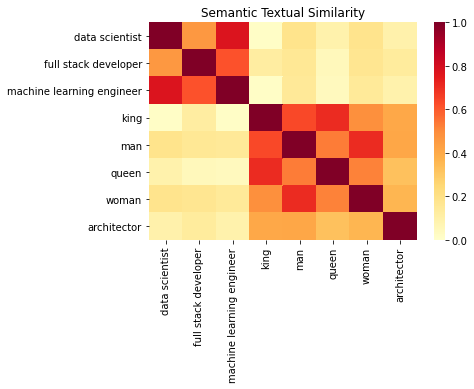

In [125]:
plot_similarity(titles_str, light_pipeline)

# Title

In [75]:
titles = titleDF.drop('description')

In [79]:
titles

DataFrame[title: string]

In [84]:
light_pipeline = train_model(titles.toDF('text'))

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [88]:
get_similarity(['data scientist','full stack developer', 'machine learning engineer','coach'], light_pipeline)

array([[0.99999988, 0.46438187, 0.77487063, 0.23825582],
       [0.46438187, 1.00000002, 0.61928708, 0.19789837],
       [0.77487063, 0.61928708, 1.0000001 , 0.18020624],
       [0.23825582, 0.19789837, 0.18020624, 1.00000002]])

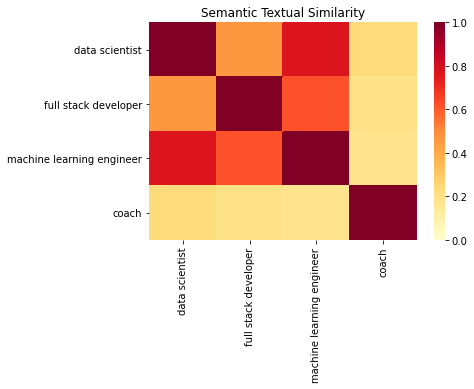

In [53]:
plot_similarity(['data scientist','full stack developer', 'machine learning engineer','coach'])

# Description

In [89]:
description = titleDF.drop('title')

In [90]:
light_pipeline = train_model(description.toDF('text'))

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [91]:
get_similarity(['data scientist','full stack developer', 'machine learning engineer','coach'], light_pipeline)

array([[0.99999988, 0.46438187, 0.77487063, 0.23825582],
       [0.46438187, 1.00000002, 0.61928708, 0.19789837],
       [0.77487063, 0.61928708, 1.0000001 , 0.18020624],
       [0.23825582, 0.19789837, 0.18020624, 1.00000002]])